# Sentiment Based Product Recommendation System
 Deployment Link: https://product-recommendation-app-0944ff2ab516.herokuapp.com/
1. **Installation of Libraries**
2. **Reading the Dataset**
3. **Exploratory Data Analysis (EDA)**
4. **Data Cleaning and Preprocessing**
5. **Text Preprocessing**
6. **Feature Extraction**
7. **Build Model for Sentiment-based Classification**  
   _Build 3 different models, evaluate, and choose the best model._
8. **Build Recommendation System**  
   _Build both User-based and Item-based recommenders, evaluate, and choose the best one._
9. **Recommend Top 20 Products to a Specific User**  
   *Using the finalised model and finalised recommendation system*
10. **Fine-tune Recommendation System**  
   _Filter and Recommend Top 5 personalized products._
11. **Deployment**  
   *Using Flask framework, Heroku (to host web application on cloud)*

### 1.Importing libraries

In [630]:
# importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
import os


In [631]:
import re
import nltk

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

import time
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize, WhitespaceTokenizer
from nltk.stem.wordnet import WordNetLemmatizer

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [632]:
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import MinMaxScaler


### 2. Reading the Dataset

In [634]:
df = pd.read_csv('sample30.csv')

In [635]:
df.head(5)

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the...,Just Awesome,Los Angeles,NaN,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part...,Good,NaN,NaN,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,NaN,NaN,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,I read through the reviews on here before look...,Disappointed,NaN,NaN,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel cau...,Irritation,NaN,NaN,walker557,Negative


Note - In Row10 reviews_doRecommend = False,reviews_title=Don't buy,still user_sentiment=Positive.There may be many more errors like this in data which need to be rectified

### 3. Exploratory Data Analysis

In [638]:
df.shape

(30000, 15)

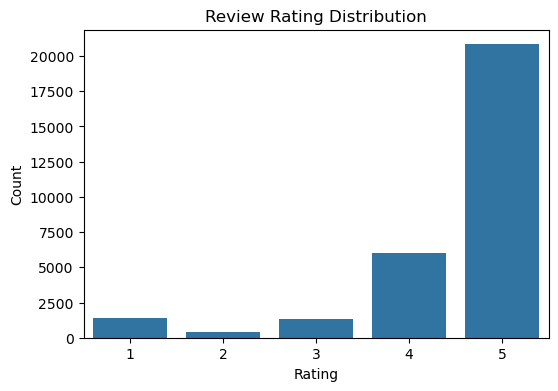

In [639]:
# Plot Distribution of ratings
plt.figure(figsize=(6, 4))
sns.countplot(x='reviews_rating', data=df)
plt.title("Review Rating Distribution")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()


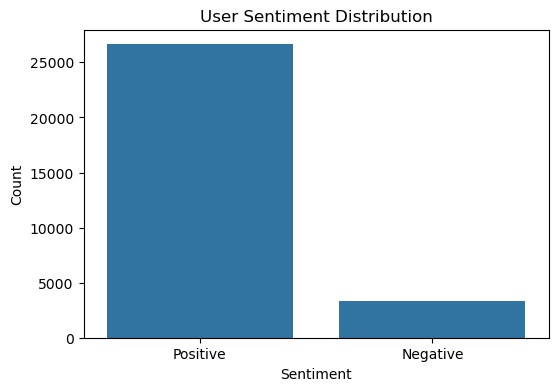

In [640]:
# Plot Sentiment distribution
plt.figure(figsize=(6, 4))
sns.countplot(x = 'user_sentiment', data = df)
plt.title("User Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()


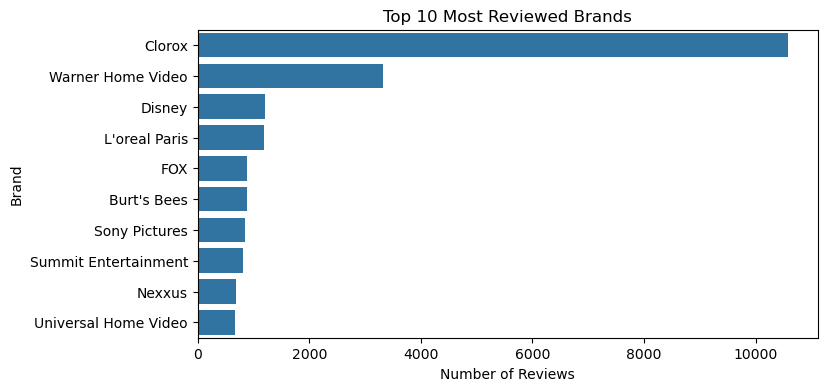

In [641]:
# Plot Top 10 brands by review count
top_brands = df['brand'].value_counts().nlargest(10)
plt.figure(figsize=(8, 4))
sns.barplot(x=top_brands.values, y=top_brands.index)
plt.title("Top 10 Most Reviewed Brands")
plt.xlabel("Number of Reviews")
plt.ylabel("Brand")
plt.show()


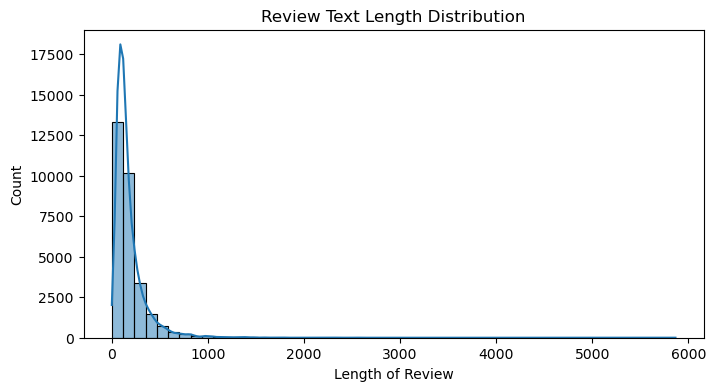

In [642]:
# Plot Review text length distribution
df['review_length'] = df['reviews_text'].astype(str).apply(len)
plt.figure(figsize=(8, 4))
sns.histplot(df['review_length'], bins=50, kde=True)
plt.title("Review Text Length Distribution")
plt.xlabel("Length of Review")
plt.show()


C:\Users\Admin\AppData\Local\Temp\ipykernel_8312\1586416411.py:3: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['reviews_month'] = df['reviews_date'].dt.to_period('M')


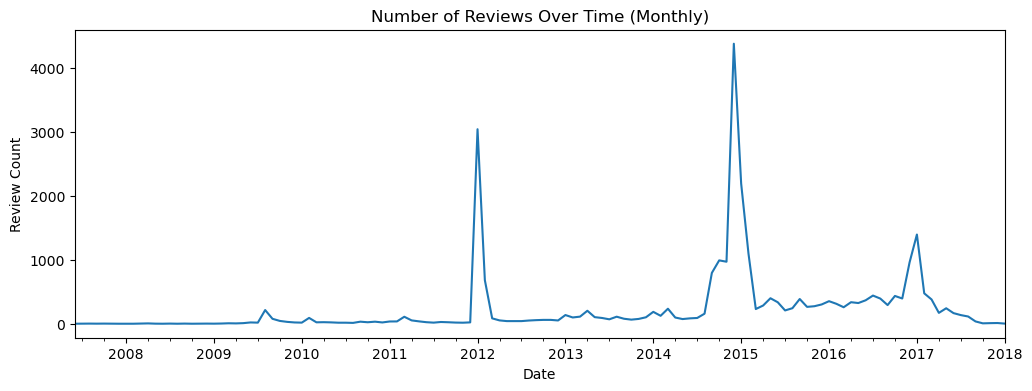

In [643]:
# Plot Count of  Monthly reviews
df['reviews_date'] = pd.to_datetime(df['reviews_date'], errors='coerce')
df['reviews_month'] = df['reviews_date'].dt.to_period('M')
monthly_counts = df['reviews_month'].value_counts().sort_index()
plt.figure(figsize=(12, 4))
monthly_counts.plot()
plt.title("Number of Reviews Over Time (Monthly)")
plt.xlabel("Date")
plt.ylabel("Review Count")
plt.show()

In [644]:
# Checking for missing values in data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype              
---  ------                --------------  -----              
 0   id                    30000 non-null  object             
 1   brand                 30000 non-null  object             
 2   categories            30000 non-null  object             
 3   manufacturer          29859 non-null  object             
 4   name                  30000 non-null  object             
 5   reviews_date          29255 non-null  datetime64[ns, UTC]
 6   reviews_didPurchase   15932 non-null  object             
 7   reviews_doRecommend   27430 non-null  object             
 8   reviews_rating        30000 non-null  int64              
 9   reviews_text          30000 non-null  object             
 10  reviews_title         29810 non-null  object             
 11  reviews_userCity      1929 non-null   object             
 12  revi

We can see that user_sentiment has 1 row NaN, review_doRecommend has 2570 Nan's, review_title has 190 NaN's, review_username also has 63 NaN. now we need username to recommenddation so remove them, so lets do some cleaning.

### 4.Data Cleaning and Pre-processing

In [647]:
df.isnull().sum()

id                          0
brand                       0
categories                  0
manufacturer              141
name                        0
reviews_date              745
reviews_didPurchase     14068
reviews_doRecommend      2570
reviews_rating              0
reviews_text                0
reviews_title             190
reviews_userCity        28071
reviews_userProvince    29830
reviews_username           63
user_sentiment              1
review_length               0
reviews_month             745
dtype: int64

Drop Columns with greater than 95% missing values

In [649]:
# Drop columns with excessive missing values (e.g., > 95% missing)
threshold = 0.95
missing_ratio = df.isnull().mean()
cols_to_drop = missing_ratio[missing_ratio > threshold].index.tolist()
df.drop(columns=cols_to_drop, inplace=True)

Drop rows that have NULL values / Replace NaN with meaningful values

In [651]:

# Drop rows with missing target variable 
#df = df.dropna(subset=['user_sentiment']).copy()

# 2. Safely fill missing values
#df.loc[:, 'reviews_title'] = df['reviews_title'].fillna("No Title")
#df.loc[:, 'reviews_didPurchase'] = df['reviews_didPurchase'].fillna("Unknown")
#df.loc[:, 'reviews_doRecommend'] = df['reviews_doRecommend'].fillna("Unknown")
#df.loc[:, 'manufacturer'] = df['manufacturer'].fillna("Unknown")
#df.loc[:, 'reviews_username'] = df['reviews_username'].fillna("Anonymous")
#df.loc[:, 'reviews_userCity'] = df['reviews_userCity'].fillna("Unknown")
#df.loc[:, 'reviews_date'] = df['reviews_date'].ffill()

# dropping rows that have null values
df = df[~df['reviews_doRecommend'].isnull()]
df = df[~df['reviews_username'].isnull()]
df = df[~df['user_sentiment'].isnull()]

In [652]:
df.shape

(27395, 16)

In [653]:
# check again for null values
df.isnull().sum()

id                         0
brand                      0
categories                 0
manufacturer             141
name                       0
reviews_date               8
reviews_didPurchase    11925
reviews_doRecommend        0
reviews_rating             0
reviews_text               0
reviews_title             24
reviews_userCity       25834
reviews_username           0
user_sentiment             0
review_length              0
reviews_month              8
dtype: int64

In [654]:
df['user_sentiment'].value_counts()

user_sentiment
Positive    24459
Negative     2936
Name: count, dtype: int64

convert the user_sentiment to Negative when reviews_doRecommend is False or reviews_rating < 3.

In [656]:
df.loc[(df['reviews_doRecommend'] == False) | (df['reviews_rating'] < 3), 'user_sentiment'] = 'Negative'

In [657]:
df['user_sentiment'].value_counts()

user_sentiment
Positive    23396
Negative     3999
Name: count, dtype: int64

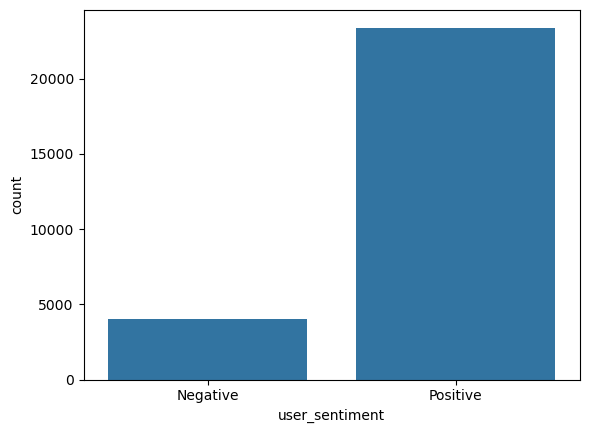

In [658]:
# plot to see the ratio of user_sentiment
plt.figure()
sns.countplot(x = 'user_sentiment', data = df)
plt.show()

Creating a column 'sentiment_label' which represents Positive sentiments -1 , Negative sentiments- 0

In [660]:
# check for values in 'user_sentiment'
#df['user_sentiment'].unique()
df['user_sentiment'].value_counts()

user_sentiment
Positive    23396
Negative     3999
Name: count, dtype: int64

In [661]:
# create a numeric label for sentiments
df['sentiment_label'] = df['user_sentiment'].map({'Positive': 1, 'Negative': 0})

### 5.Text Preprocessing

In [663]:
# Define custom stopwords
stopwords = set([
    'a', 'an', 'the', 'and', 'or', 'but', 'if', 'while', 'with', 'of', 'at', 'by',
    'for', 'to', 'in', 'on', 'is', 'are', 'was', 'were', 'be', 'been', 'has', 'had',
    'have', 'this', 'that', 'it', 'as', 'from', 'not', 'will', 'would', 'can', 'could',
    'no', 'never', 'nothing', 'neither', 'none', 'nowhere',
    'should', 'shall', 'i', 'you', 'he', 'she', 'they', 'we', 'me', 'him', 'her', 'them', 'my', 'your',
    "doesn't", "don't", "can't", "won't", "isn't", "wasn't", "shouldn't", "wouldn't", "couldn't"
])


In [664]:
lemmatizer = WordNetLemmatizer()

In [665]:
# Preprocessing function
def preprocess_text(text):
    if pd.isna(text):
        return ""
    # lowering case
    text = text.lower()
    # remove punctuation/numbers
    text = re.sub(r'[^a-z\s]', ' ', text)
    # tokenize
    tokens = text.split()
    # remove stopwords
    tokens = [word for word in tokens if word not in stopwords]
    # Remove short/empty tokens
    tokens = [word for word in tokens if len(word) > 1]
    # Lemmatizing Text
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    # concatenating words
    return ' '.join(tokens)


In [666]:
# Apply to reviews_text column
df['cleaned_reviews_text'] = df['reviews_text'].apply(preprocess_text)

In [667]:
print(df[['reviews_text', 'cleaned_reviews_text']].head(10))

                                         reviews_text  \
3   I read through the reviews on here before look...   
4   My husband bought this gel for us. The gel cau...   
5   My boyfriend and I bought this to spice things...   
6   Bought this earlier today and was excited to c...   
7   I bought this product for my husband and I to ...   
8   My husband and I bought this for some extra fu...   
9   Got as a surprise for my husband there is noth...   
10  tried it with my husband and felt no different...   
11  Purchased this thinking it would have some sor...   
12  Bought this to enhance our time a bit, did abs...   

                                 cleaned_reviews_text  
3   read through review here before looking buying...  
4   husband bought gel u gel caused irritation fel...  
5   boyfriend bought spice thing up bedroom both h...  
6   bought earlier today excited check out based p...  
7   bought product husband try impressed all there...  
8   husband bought some extra fun we

### 6.Feature extraction - TF-IDF Features

In [669]:
# Preprocess stopwords to match your text preprocessing
processed_stopwords = set()
for word in stopwords:
    word = word.lower()
    word = re.sub(r'[^a-z\s]', '', word)  # remove punctuation
    if len(word) > 1:
        processed_stopwords.add(word)

word_vectorizer = TfidfVectorizer(
    strip_accents = 'unicode',
    analyzer = 'word',
    token_pattern = r'\w{1,}',
    ngram_range = (1, 3),
    stop_words = list(processed_stopwords),
    sublinear_tf = True)

tfidf_data = word_vectorizer.fit_transform(df['cleaned_reviews_text'])

### Pickle file - Save TF-IDF

In [671]:
# Folder name
subfolder = "pickle"

# Create the folder if it doesn't exist
os.makedirs(subfolder, exist_ok=True)

# Full file path
filename = os.path.join(subfolder, "tfidf_vectorizer.pkl")

with open(filename, 'wb') as file:
    pickle.dump(word_vectorizer, file)

In [672]:
df['sentiment_label'].shape

(27395,)

In [674]:
### Pickle file - Save the cleaned Dataset

In [675]:
# Full file path
filename = os.path.join(subfolder, "df.pkl")

with open(filename, 'wb') as file:
    pickle.dump(df, file)


### 7.Build Sentiment-based Classification Model

### 7.1.Split into Test and Train data

In [678]:
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(
    tfidf_data,                     # Features (TF-IDF matrix)
    df['sentiment_label'],          # Target labels (0 or 1)
    test_size=0.2,                  # 20% data for testing
    random_state=3                  # Seed for reproducibility
)

In [679]:
print(X_train_tfidf.shape)
print(X_test_tfidf.shape)
print(y_train_tfidf.shape)
print(y_test_tfidf.shape)

(21916, 519202)
(5479, 519202)
(21916,)
(5479,)


### 7.2.Handling Class Imbalance

In [681]:

print("Before SMOTE:")
print(y_train_tfidf.value_counts())

sm = SMOTE()
# transform the dataset
X_train_tfidf_sm, y_train_tfidf_sm = sm.fit_resample(X_train_tfidf, y_train_tfidf)

# Check class distribution after applying SMOTE
print("\nAfter SMOTE:")
print(y_train_tfidf_sm.value_counts())

Before SMOTE:
sentiment_label
1    18712
0     3204
Name: count, dtype: int64

After SMOTE:
sentiment_label
0    18712
1    18712
Name: count, dtype: int64


### 7.3. Model 1 - LOGISTIC REGRESSION

In [683]:
X_train_tfidf_sm.shape,y_train_tfidf_sm.shape

((37424, 519202), (37424,))

Build the Model

In [685]:

# Start time
start = time.perf_counter()

# Initialize and train the logistic regression model
lr = LogisticRegression()
lr.fit(X_train_tfidf_sm, y_train_tfidf_sm)

# End time
end = time.perf_counter()

# Print time taken
print(f"Training time: {end - start:.2f} seconds")

Training time: 1.00 seconds


Predict on test data

In [687]:
# Predicting Test Data with SMOTE
y_pred_test_lr = lr.predict(X_test_tfidf)

Evaluation of Model 1

In [689]:
def printEvaluationReport(y, pred):
    # Print the classification report with precision, recall, F1-score, and support
    print(classification_report(y, pred))

    # Print overall accuracy of the model
    print('Accuracy : ', accuracy_score(y, pred))

    # Print F1-score (harmonic mean of precision and recall)
    print('F1 score: ', f1_score(y, pred))

    # Print recall (true positive rate)
    print('Recall: ', recall_score(y, pred))

    # Print precision (positive predictive value)
    print('Precision: ', precision_score(y, pred))
    print('')

    # Print the confusion matrix (actual vs. predicted)
    print('Confusion Matrix: ')
    print(confusion_matrix(pred, y))

In [690]:
print("===========================================================")
print("Logistic Regression Evaluation on Test set ")
print("===========================================================")
# Print overall accuracy of the model
print('Accuracy : ', accuracy_score(y_test_tfidf, y_pred_test_lr))

# Print precision (positive predictive value)
print('Precision: ', precision_score(y_test_tfidf, y_pred_test_lr))

# Print recall (true positive rate)
print('Recall: ', recall_score(y_test_tfidf, y_pred_test_lr))

# Print F1-score (harmonic mean of precision and recall)
print('F1 score: ', f1_score(y_test_tfidf, y_pred_test_lr))


Logistic Regression Evaluation on Test set 
Accuracy :  0.8992516882642818
Precision:  0.9528715475668567
Recall:  0.9280529461998293
F1 score:  0.9402985074626866


### Pickle file - Save LogisticRegressionModel

In [692]:
# Save model to pickle file 

# Full file path
filename = os.path.join(subfolder, "logistic_regression_model.pkl")

with open(filename, 'wb') as file:
    pickle.dump(lr, file)

### 7.4.Model 2 - RANDOM FOREST CLASSIFIER

#### Build Model

In [695]:
params = {
    'max_features': [10, 20, 30],
    'max_depth': [10, 15, 20],
    'min_samples_leaf': [1, 2, 5, 10],
    'min_samples_split': [2, 5, 10, 20],
    #'min_samples_leaf': [50, 100, 150, 200],
    #'min_samples_split': [100, 150, 200],
    'n_estimators': [100, 200, 300],
}

rf = RandomForestClassifier()


# Create the randomized search object
#random_search = RandomizedSearchCV(
#                                    estimator=rf,
#                                    param_distributions=params,
#                                    n_iter=50, # Number of random combinations to try
#                                    cv=4,      # 4-fold cross-validation
#                                    scoring='precision', # Evaluation metric
#                                    n_jobs=-1,           # Use all CPU cores
#                                    verbose=1,           # Show progress
#                                    random_state=42      # Reproducibility
#)

In [696]:


# Start time
start = time.perf_counter()

#random_search.fit(X_train_tfidf_sm, y_train_tfidf_sm)

# End time
end = time.perf_counter()

# Print time taken
print(f"Training time: {end - start:.2f} seconds")

Training time: 0.00 seconds


Check for best parameters

In [698]:
#print('Best Precision Score', random_search.best_score_)
#print('Best Estimator', random_search.best_estimator_)
#print('Best Params', random_search.best_params_)

Best Precision Score 0.709730498267928
Best Estimator RandomForestClassifier(max_depth=10, max_features=20, min_samples_leaf=10,
                       min_samples_split=20)
Best Params {'n_estimators': 100, 'min_samples_split': 20, 'min_samples_leaf': 10, 'max_features': 20, 'max_depth': 10}

Build Model again with best parameters

In [701]:
#best_params = random_search.best_params_
best_params = {
    'max_features': 20,
    'max_depth': 10,
    'min_samples_leaf': 10,
    'min_samples_split': 20,
    'n_estimators': 100
}
best_rf = RandomForestClassifier(
    **best_params,
    n_jobs=-1,
    random_state=42
)

# Step 7: Train new model on full training data
start = time.perf_counter()
best_rf.fit(X_train_tfidf_sm, y_train_tfidf_sm)
end = time.perf_counter()


Predict on test data

In [703]:
y_pred_test_rfc = best_rf.predict(X_test_tfidf)

Evaluation of Model 2

In [705]:
# Model Performance on Test Dataset
print("===========================================================")
print("Random Forest Classifier Evaluation on Test set ")
print("===========================================================")

print("Accuracy :", accuracy_score(y_test_tfidf, y_pred_test_rfc))
print("Precision:", precision_score(y_test_tfidf, y_pred_test_rfc))
print("Recall   :", recall_score(y_test_tfidf, y_pred_test_rfc))
print("F1 Score :", f1_score(y_test_tfidf, y_pred_test_rfc))

Random Forest Classifier Evaluation on Test set 
Accuracy : 0.8496075926263916
Precision: 0.8680396643783371
Recall   : 0.9718189581554227
F1 Score : 0.9170024174053183


### 7.5.Model 3- **Naive Bayes**

In [707]:
from sklearn.naive_bayes import MultinomialNB

In [708]:
nb = MultinomialNB()

In [709]:
# Start time
start = time.perf_counter()

nb.fit(X_train_tfidf_sm, y_train_tfidf_sm)

# End time
end = time.perf_counter()

# Print time taken
print(f"Training time: {end - start:.2f} seconds")

Training time: 0.04 seconds


Predict on test data

In [711]:
# predicting test data
y_pred_test_nb = nb.predict(X_test_tfidf)

Evaluate Model 3

In [713]:
print("===========================================================")
print("Naive Bayes Classifier Evaluation on Test set ")
print("===========================================================")
# Accuracy
print('Accuracy : ', accuracy_score(y_test_tfidf, y_pred_test_nb))

# Precision (positive predictive value)
print('Precision: ', precision_score(y_test_tfidf, y_pred_test_nb))

# Recall (true positive rate)
print('Recall: ', recall_score(y_test_tfidf, y_pred_test_nb))

# F1-score (harmonic mean of precision and recall)
print('F1 score: ', f1_score(y_test_tfidf, y_pred_test_nb))


Naive Bayes Classifier Evaluation on Test set 
Accuracy :  0.8729695199853988
Precision:  0.934612031386225
Recall:  0.9154568744662681
F1 score:  0.9249352890422778


**NOTE - From above 3 different models , the performance of Logistic Regression model is better than the other two. Hence, we will consider the Logistic Regression model as our final model for the prediction.**

### 8.**Recommendation System**

### 8.1. Split data into Test and Train

In [718]:
# doing train and test split
train, test = train_test_split(df, test_size = 0.2, random_state = 3)

In [719]:
print(train.shape)
print(test.shape)

(21916, 18)
(5479, 18)


### 8.2. Convert data into pivot matrix format with rows as usernames, columns as product

In [722]:
df_pivot = train.pivot_table(
    index = 'reviews_username',
    columns = 'id',
    values = 'reviews_rating'
).fillna(0)

In [723]:
#print(df_pivot.shape)


# 8.3.Creating dummy train dataset (which can be used later for prediction of products that are not rated by the User)
Mark products rated by User as 0 and products not rated by User as 1

In [726]:
# creating train dummy
dummy_train = train.copy()

In [727]:
# marking not rated products as 1
dummy_train['reviews_rating'] = dummy_train['reviews_rating'].apply(lambda x : 0 if x >= 1 else 1)

In [728]:
# creating matrix pivot table of dummy train
dummy_train = dummy_train.pivot_table(
    index = 'reviews_username',
    columns = 'id',
    values = 'reviews_rating'
).fillna(1)

In [729]:
dummy_train

id,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YneDPglJLPUi8IJyQ,AV1Yo6FPglJLPUi8IK3u,AV1YpiJvvKc47QAVguxy,...,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfsQoeilAPnD_xgfx5,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
01impala,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
02dakota,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
02deuce,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
06stidriver,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zxcsdfd,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
zxjki,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
zyiah4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


### 8.4. Create Similarity Matrix - computing Adjusted Cosine Similarity

In [731]:
mean = np.nanmean(df_pivot, axis=1)
df_subtracted = (df_pivot.T-mean).T

# Creating the User Similarity Matrix using pairwise_distance function.
user_correlation = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
user_correlation[np.isnan(user_correlation)] = 0
print(user_correlation)

[[ 1.         -0.00497512 -0.00497512 ... -0.00497512  1.
  -0.00497512]
 [-0.00497512  1.          1.         ... -0.00497512 -0.00497512
  -0.00497512]
 [-0.00497512  1.          1.         ... -0.00497512 -0.00497512
  -0.00497512]
 ...
 [-0.00497512 -0.00497512 -0.00497512 ...  1.         -0.00497512
   1.        ]
 [ 1.         -0.00497512 -0.00497512 ... -0.00497512  1.
  -0.00497512]
 [-0.00497512 -0.00497512 -0.00497512 ...  1.         -0.00497512
   1.        ]]


In [732]:
user_correlation.shape

(19029, 19029)

### 8.5. **User - User similarity prediction**

Ignore Correlation that is lesser than 0

In [735]:
user_correlation[user_correlation < 0] = 0
user_correlation

array([[1., 0., 0., ..., 0., 1., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 1.],
       [1., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 1.]])

Predict Rating by the user which is equal to  weighted sum of correlation with the product rating

In [737]:
# calculate dot product between correlation matrix and ratings
user_predicted_ratings = np.dot(user_correlation, df_pivot.fillna(0))
user_predicted_ratings

array([[ 0.        , 14.97746482,  0.        , ...,  0.        ,
         1.53938407,  0.        ],
       [ 3.45134525, 24.54928326,  0.        , ...,  0.        ,
         3.60388445,  0.        ],
       [ 3.45134525, 24.54928326,  0.        , ...,  0.        ,
         3.60388445,  0.        ],
       ...,
       [ 0.42562841, 13.05303461,  0.        , ...,  0.        ,
         3.52672808,  0.        ],
       [ 0.        , 14.97746482,  0.        , ...,  0.        ,
         1.53938407,  0.        ],
       [ 0.42562841, 13.05303461,  0.        , ...,  0.        ,
         3.52672808,  0.        ]])

In [738]:
user_predicted_ratings.shape

(19029, 202)

As we are only interested in the products that are not yet rated by the user, so we'll make product rated by user as 0.

In [740]:
# multiply ratings with dummy train
user_rating = np.multiply(user_predicted_ratings, dummy_train)
user_rating

id,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YneDPglJLPUi8IJyQ,AV1Yo6FPglJLPUi8IK3u,AV1YpiJvvKc47QAVguxy,...,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfsQoeilAPnD_xgfx5,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,0.000000,14.977465,0.0,0.0,1.778823,0.000000,2.213707,0.000000,0.0,0.0,...,1.745958,0.414697,2.872353,0.0,1.539384,0.0,0.0,0.0,1.539384,0.0
01impala,3.451345,24.549283,0.0,0.0,0.000000,1.703975,0.000000,1.599476,0.0,0.0,...,1.745958,0.000000,0.000000,0.0,1.417603,0.0,0.0,0.0,3.603884,0.0
02dakota,3.451345,24.549283,0.0,0.0,0.000000,1.703975,0.000000,1.599476,0.0,0.0,...,1.745958,0.000000,0.000000,0.0,1.417603,0.0,0.0,0.0,3.603884,0.0
02deuce,3.451345,24.549283,0.0,0.0,0.000000,1.703975,0.000000,1.599476,0.0,0.0,...,1.745958,0.000000,0.000000,0.0,1.417603,0.0,0.0,0.0,3.603884,0.0
06stidriver,0.425628,13.053035,0.0,0.0,2.872353,3.526728,4.588755,0.000000,0.0,0.0,...,0.000000,0.414697,0.000000,0.0,0.000000,0.0,0.0,0.0,3.526728,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zxcsdfd,0.425628,13.053035,0.0,0.0,2.872353,3.526728,4.588755,0.000000,0.0,0.0,...,0.000000,0.414697,0.000000,0.0,0.000000,0.0,0.0,0.0,3.526728,0.0
zxjki,0.425628,13.053035,0.0,0.0,2.872353,3.526728,4.588755,0.000000,0.0,0.0,...,0.000000,0.414697,0.000000,0.0,0.000000,0.0,0.0,0.0,3.526728,0.0
zyiah4,0.425628,13.053035,0.0,0.0,2.872353,3.526728,4.588755,0.000000,0.0,0.0,...,0.000000,0.414697,0.000000,0.0,0.000000,0.0,0.0,0.0,3.526728,0.0



Mapping product id with product name

In [742]:
mapped = df[['id', 'name',  'brand', 'manufacturer']]
mapped = pd.DataFrame.drop_duplicates(mapped)
mapped

,id,name,brand,manufacturer
3,AV16khLE-jtxr-f38VFn,K-Y Love Sensuality Pleasure Gel,K-Y,K-Y
31,AV1d76w7vKc47QAVhCqn,"J.R. Watkins Hand Cream, Lemon Cream",J.R. Watkins,J.R. Watkins
36,AV1h6gSl-jtxr-f31p40,Ambi Complexion Cleansing Bar,AMBI,FLEMING & CO
40,AV1h6Gu0glJLPUi8IjA_,"Johnson's Baby Bubble Bath and Wash, 15oz",Johnson's,Johnson's
54,AV1l8zRZvKc47QAVhnAv,Olay Regenerist Deep Hydration Regenerating Cream,Olay,P&G
...,...,...,...,...
28763,AVpfUQZjilAPnD_xZfOU,Bedtime Originals Pinkie Musical Mobile,Bedtime Originals,Lambs and Ivy Inc
28770,AVpfv4TlilAPnD_xhjNS,Various - Red Hot Blue:Tribute To Cole Porter ...,Target.com Use Only,Capitol
28795,AVpfVMhR1cnluZ0-ixY8,2017-2018 Brownline174 Duraflex 14-Month Plann...,Brownline,120
28799,AVpfVPh3ilAPnD_xZzW9,Mrs. Meyer's Lemon Verbena Surface Scrub,Mrs. Meyer's,Mrs. Meyers


In [743]:
# Full file path
filename = os.path.join(subfolder, "product_id_name_mapped.pkl")

with open(filename, 'wb') as file:
    pickle.dump(mapped, file)

#### 8.5.1. Evaluation of User User recommendation

 1. Filter Users Present in Test and Train Data

In [746]:
# Keep only the test users who are also present in the training dataset
common = test[test.reviews_username.isin(train.reviews_username)]
common

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_username,user_sentiment,review_length,reviews_month,sentiment_label,cleaned_reviews_text
17653,AVpfBrUZilAPnD_xTUly,Coty,"Personal Care,Makeup,Concealer & Foundation,Fo...",Coty brands,"Coty Airspun Face Powder, Translucent Extra Co...",2015-03-19 00:00:00+00:00,True,True,5,Love it. This is by far the best setting powde...,love it,NaN,shopsalot505,Positive,899,2015-03,1,love far best setting powder ever used really ...
8993,AVpf3VOfilAPnD_xjpun,Clorox,"Household Essentials,Cleaning Supplies,Kitchen...",Clorox,Clorox Disinfecting Wipes Value Pack Scented 1...,2015-01-20 03:23:21+00:00,NaN,True,5,Very easy and convenient. Bad season for sickn...,Wipes,Suffolk,theresa79,Negative,173,2015-01,0,very easy convenient bad season sickness use d...
22581,AVpfOmKwLJeJML435GM7,Clear Scalp & Hair Therapy,"Personal Care,Hair Care,Shampoo,Featured Brand...",Clear,Clear Scalp & Hair Therapy Total Care Nourishi...,2016-02-18 23:27:12+00:00,NaN,True,4,Cleans and condtions well with no buildup or g...,Good Everyday Shampoo,Tacoma,k1971,Positive,148,2016-02,1,clean condtions well buildup greasy residue le...
4185,AVpe9W4D1cnluZ0-avf0,Hoover,"Home,Home Appliances,Vacuums & Floor Care,Upri...",Hoover,Hoover174 Platinum Collection153 Lightweight B...,2010-09-21 00:00:00+00:00,False,True,4,This upright vaccum does all it claims to do. ...,Best vacuum I have had thus far.,NaN,cleaner mom,Positive,286,2010-09,1,upright vaccum doe all claim do only downfall ...
14667,AVpf3VOfilAPnD_xjpun,Clorox,"Household Essentials,Cleaning Supplies,Kitchen...",Clorox,Clorox Disinfecting Wipes Value Pack Scented 1...,2012-02-14 00:00:00+00:00,False,True,5,"These are great when in a hurry. Plus, they le...",Convenient and fresh!,NaN,jillian4,Positive,78,2012-02,1,these great when hurry plus leave apartment sm...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18829,AVpfJP1C1cnluZ0-e3Xy,Clorox,"Household Chemicals,Household Cleaners,Bath & ...",AmazonUs/CLOO7,Clorox Disinfecting Bathroom Cleaner,2012-01-26 03:04:46+00:00,NaN,True,4,This bathroom cleaner smells greats and takes ...,This Product Does The Best Job When It Comes T...,Birmingham,coupons2get,Negative,88,2012-01,0,bathroom cleaner smell great take care toughes...
18015,AVpfcu821cnluZ0-k8ep,Vaseline,"Personal Care,Skin Care,Lip Care,Beauty,Makeup...",UNILEVER,Vaseline Intensive Care Lip Therapy Cocoa Butter,2015-04-29 02:28:57+00:00,NaN,True,5,Love this product. Its amazing. Made my lips s...,Wonderful,NaN,mimi3,Positive,73,2015-04,1,love product it amazing made lip super soft si...
29561,AVpfW8y_LJeJML437ySW,L'oreal Paris,"Beauty,Hair Care,Shampoo & Conditioner,Holiday...",L'oreal Paris,L'or233al Paris Elvive Extraordinary Clay Reba...,2017-01-27 16:26:29+00:00,NaN,True,4,"Oily hair girls, this is for you. The Clay con...",Works Great In Combination With Shampoo & Mask,Charlotte,lisbet1388,Positive,734,2017-01,1,oily hair girl clay conditioner work great com...
9293,AVpf3VOfilAPnD_xjpun,Clorox,"Household Essentials,Cleaning Supplies,Kitchen...",Clorox,Clorox Disinfecting Wipes Value Pack Scented 1...,2014-12-05 12:36:42+00:00,NaN,True,5,The Clorox wipes is the best thing when it com...,Clean Wipes,NaN,stuffie9663,Positive,144,2014-12,1,clorox wipe best thing when come cleaning bath...


In [747]:
common.shape


(1250, 18)

2. Create User-Item Rating Matrix for Common Users

In [749]:
# Rows: usernames, Columns: item IDs, Values: ratings
common_user_matrix = common.pivot_table(
    index = 'reviews_username',
    columns = 'id',
    values = 'reviews_rating'
)

common_user_matrix


id,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YneDPglJLPUi8IJyQ,AV1Ys0kTvKc47QAVgx1C,AV1ZSp2uglJLPUi8IQFy,AV1ZT7GLglJLPUi8IQLI,...,AVpfl6sF1cnluZ0-nmwC,AVpfm8yiLJeJML43AYyu,AVpfnRuSilAPnD_xfB8l,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrgjFLJeJML43BvCc,AVpfthSailAPnD_xg3ON,AVpfv4TlilAPnD_xhjNS
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1234567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
123charlie,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1943,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4cloroxl,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
yohnie1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
zapman,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
zipper,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


3. Prepare User Correlation DataFrame

In [751]:
# convert user_correlation[Precomputed user similarity matrix] to dataframe
user_correlation_df = pd.DataFrame(user_correlation)
user_correlation_df

,0,1,2,3,4,5,6,7,8,9,...,19019,19020,19021,19022,19023,19024,19025,19026,19027,19028
0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.464023,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.464023,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.464023,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.464023,1.0,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19024,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.464023,1.0,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0
19025,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.464023,1.0,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0
19026,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.464023,1.0,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0
19027,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [752]:
# Add usernames as index
user_correlation_df['reviews_username'] = df_subtracted.index
user_correlation_df.set_index('reviews_username',inplace=True)
user_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,...,19019,19020,19021,19022,19023,19024,19025,19026,19027,19028
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
01impala,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.464023,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02dakota,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.464023,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02deuce,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.464023,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
06stidriver,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.464023,1.0,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0


4. Filter User Correlation for Relevant Users

In [754]:
list_name = common.reviews_username.tolist()

user_correlation_df.columns = df_subtracted.index.tolist()


# Keep only correlations between users present in 'common'
user_correlation_df_1 =  user_correlation_df[user_correlation_df.index.isin(list_name)]
user_correlation_df_2 = user_correlation_df_1.T[user_correlation_df_1.T.index.isin(list_name)]
user_correlation_df3 = user_correlation_df_2.T
user_correlation_df3.shape

(1103, 1103)

In [755]:
user_correlation_df3

,00sab00,1234567,123charlie,1943,4cloroxl,50cal,85lisa,8ellie24,abby,abcdef,...,worm,xlivayy,yayatex,yeya,yoadrian,yohnie1,zapman,zipper,zippy,zxcsdfd
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,1.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
1234567,0.0,1.000000,0.000000,0.000000,1.000000,0.0,1.000000,1.000000,0.000000,0.000000,...,0.0,0.0,1.000000,1.000000,0.000000,0.705346,0.0,0.000000,0.000000,1.000000
123charlie,0.0,0.000000,1.000000,0.511353,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,1.000000,0.000000,0.0,1.000000,0.597448,0.000000
1943,0.0,0.000000,0.511353,1.000000,0.000000,0.0,0.000000,0.000000,0.602524,0.856816,...,0.0,0.0,0.000000,0.000000,0.511353,0.000000,0.0,0.511353,0.302061,0.000000
4cloroxl,0.0,1.000000,0.000000,0.000000,1.000000,0.0,1.000000,1.000000,0.000000,0.000000,...,0.0,0.0,1.000000,1.000000,0.000000,0.705346,0.0,0.000000,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
yohnie1,0.0,0.705346,0.000000,0.000000,0.705346,0.0,0.705346,0.705346,0.000000,0.000000,...,0.0,0.0,0.705346,0.705346,0.000000,1.000000,0.0,0.000000,0.000000,0.705346
zapman,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000
zipper,0.0,0.000000,1.000000,0.511353,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,1.000000,0.000000,0.0,1.000000,0.597448,0.000000


5. Remove Negative Correlations

In [757]:
# Mark negative similarity to 0 (only positive similarities are considered)
user_correlation_df3[user_correlation_df3 < 0] = 0
user_correlation_df3

,00sab00,1234567,123charlie,1943,4cloroxl,50cal,85lisa,8ellie24,abby,abcdef,...,worm,xlivayy,yayatex,yeya,yoadrian,yohnie1,zapman,zipper,zippy,zxcsdfd
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,1.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
1234567,0.0,1.000000,0.000000,0.000000,1.000000,0.0,1.000000,1.000000,0.000000,0.000000,...,0.0,0.0,1.000000,1.000000,0.000000,0.705346,0.0,0.000000,0.000000,1.000000
123charlie,0.0,0.000000,1.000000,0.511353,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,1.000000,0.000000,0.0,1.000000,0.597448,0.000000
1943,0.0,0.000000,0.511353,1.000000,0.000000,0.0,0.000000,0.000000,0.602524,0.856816,...,0.0,0.0,0.000000,0.000000,0.511353,0.000000,0.0,0.511353,0.302061,0.000000
4cloroxl,0.0,1.000000,0.000000,0.000000,1.000000,0.0,1.000000,1.000000,0.000000,0.000000,...,0.0,0.0,1.000000,1.000000,0.000000,0.705346,0.0,0.000000,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
yohnie1,0.0,0.705346,0.000000,0.000000,0.705346,0.0,0.705346,0.705346,0.000000,0.000000,...,0.0,0.0,0.705346,0.705346,0.000000,1.000000,0.0,0.000000,0.000000,0.705346
zapman,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000
zipper,0.0,0.000000,1.000000,0.511353,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,1.000000,0.000000,0.0,1.000000,0.597448,0.000000


6. Predict Ratings

In [759]:
# Multiply similarity matrix with user-item ratings matrix
common_user_pred_rating = np.dot(user_correlation_df3, common_user_matrix.fillna(0))

common_user_pred_rating

array([[0.        , 0.        , 0.        , ..., 0.        , 2.87235349,
        2.41767192],
       [0.        , 0.        , 0.        , ..., 0.        , 5.31556412,
        0.        ],
       [0.        , 0.        , 0.        , ..., 1.79216933, 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.79216933, 0.        ,
        0.        ],
       [0.79892509, 0.        , 0.        , ..., 1.03890457, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 5.31556412,
        0.        ]])

In [760]:
common_user_pred_rating.shape

(1103, 84)

7. Create Dummy Test Matrix

In [762]:
dummy_test = common.copy()
# Binary matrix: 1 if rating exists, else 0
dummy_test['reviews_rating'] = dummy_test['reviews_rating'].apply(lambda x: 1 if x>=1 else 0)

# Convert dummy test to pivot table
dummy_test = dummy_test.pivot_table(
    index='reviews_username',
    columns='id',
    values='reviews_rating').fillna(0)



In [763]:
dummy_test.shape

(1103, 84)

8. Mask Predictions for the Items that has not been rated by User

In [765]:
# Multiply to ensure that we only predict for unrated items
common_user_pred_rating = np.multiply(common_user_pred_rating, dummy_test)
common_user_pred_rating

id,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YneDPglJLPUi8IJyQ,AV1Ys0kTvKc47QAVgx1C,AV1ZSp2uglJLPUi8IQFy,AV1ZT7GLglJLPUi8IQLI,...,AVpfl6sF1cnluZ0-nmwC,AVpfm8yiLJeJML43AYyu,AVpfnRuSilAPnD_xfB8l,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrgjFLJeJML43BvCc,AVpfthSailAPnD_xg3ON,AVpfv4TlilAPnD_xhjNS
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1234567,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
123charlie,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1943,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4cloroxl,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
yohnie1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zapman,0.0,27.053456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zipper,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


 9. Create Pivot Table of Actual Ratings

In [767]:
common_pivot = common.pivot_table(
    index = 'reviews_username',
    columns = 'id',
    values = 'reviews_rating'
)
common_pivot

id,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YneDPglJLPUi8IJyQ,AV1Ys0kTvKc47QAVgx1C,AV1ZSp2uglJLPUi8IQFy,AV1ZT7GLglJLPUi8IQLI,...,AVpfl6sF1cnluZ0-nmwC,AVpfm8yiLJeJML43AYyu,AVpfnRuSilAPnD_xfB8l,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrgjFLJeJML43BvCc,AVpfthSailAPnD_xg3ON,AVpfv4TlilAPnD_xhjNS
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1234567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
123charlie,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1943,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4cloroxl,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
yohnie1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
zapman,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
zipper,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


10. Normalise Predictions to Rating Range of 1-5

In [769]:
X = common_user_pred_rating.copy()
X = X[X > 0]  # Keep only positive predictions
scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = scaler.transform(X)
print(y)

MinMaxScaler(feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


11. RMSE Evaluation

In [771]:
# finding total non NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))
total_non_nan
mse = ((y - common_pivot) ** 2).mean()
mse
rmse = (sum(mse)/total_non_nan) ** 0.5
print("===============================================================")
print(" RMSE of User based recommendation system : ")
print("===============================================================")
print(rmse)

 RMSE of User based recommendation system : 
0.7407363812298455


### **8.6. Item based Recommendation System**

In [773]:
#Creating a User-Item rating matrix from the training data
# - Rows will be users ('reviews_username')
# - Columns will be items/products ('id')
# - Values are ratings (from 'reviews_rating')

df_pivot = train.pivot_table(
    index = 'reviews_username',
    columns = 'id',
    values = 'reviews_rating'
).T

df_pivot.head(3)

reviews_username,00sab00,01impala,02dakota,02deuce,06stidriver,1085,10ten,1143mom,1234,1234561,...,zsazsa,zt313,zubb,zuttle,zwithanx,zxcsdfd,zxjki,zyiah4,zzdiane,zzz1127
id,,,,,,,,,,,,,,,,,,,,,
AV16khLE-jtxr-f38VFn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YGDqsGV-KLJ3adc-O,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YlENIglJLPUi8IHsX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Creating Similarity Matrix - using Adjusted Cosine

In [775]:
mean = np.nanmean(df_pivot, axis=1)
df_subtracted = (df_pivot.T-mean).T

# Item Similarity Matrix
item_correlation = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
item_correlation[np.isnan(item_correlation)] = 0
print(item_correlation)

[[1.         0.         0.         ... 0.         0.         0.        ]
 [0.         1.         0.         ... 0.         0.00180986 0.        ]
 [0.         0.         1.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.00180986 0.         ... 0.         1.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


Filtering the correlation only for which the value is greater than 0. (Positively correlated)

In [777]:
item_correlation[item_correlation < 0] = 0
item_correlation

array([[1.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 1.        , 0.        , ..., 0.        , 0.00180986,
        0.        ],
       [0.        , 0.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.00180986, 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

Prediction - Item Item based

In [779]:
item_pred_rating = np.dot((df_pivot.fillna(0).T), item_correlation)
item_pred_rating

array([[0.        , 0.        , 0.        , ..., 0.        , 0.00380024,
        0.        ],
       [0.01950835, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.03251391, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.00071027, 0.        , ..., 0.        , 0.00122241,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.00633373,
        0.        ],
       [0.        , 0.00056822, 0.        , ..., 0.        , 0.00097793,
        0.        ]])

Filtering the rating only for the movies not rated by the user for recommendation

In [781]:
item_rating = np.multiply(item_pred_rating,dummy_train)
item_rating.head()

id,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YneDPglJLPUi8IJyQ,AV1Yo6FPglJLPUi8IK3u,AV1YpiJvvKc47QAVguxy,...,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfsQoeilAPnD_xgfx5,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,0.000000,0.00000,0.0,0.0,0.006211,0.000000,0.004326,0.0,0.0,0.0,...,0.0,0.0,0.011371,0.0,0.0,0.0,0.0,0.0,0.003800,0.0
01impala,0.019508,0.00000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
02dakota,0.032514,0.00000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
02deuce,0.026011,0.00000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
06stidriver,0.000000,0.00071,0.0,0.0,0.001998,0.001901,0.002783,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.001222,0.0


#### 8.6.1. Evaluation of Item based recommendation

1. Filter Common Items in Train and Test Sets

In [784]:
common = test[test.id.isin(train.id)]
common

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_username,user_sentiment,review_length,reviews_month,sentiment_label,cleaned_reviews_text
9846,AVpf3VOfilAPnD_xjpun,Clorox,"Household Essentials,Cleaning Supplies,Kitchen...",Clorox,Clorox Disinfecting Wipes Value Pack Scented 1...,2015-02-24 00:00:00+00:00,False,True,5,Love Clorox wipes! Use them daily for all mess...,LOVE!,NaN,smi95,Positive,162,2015-02,1,love clorox wipe use daily all mess around hou...
22275,AVpfOIrkilAPnD_xXgDG,Summit Entertainment,"Movies & TV Shows,Instawatch Movies By VUDU,In...",NaN,Alex Cross (dvdvideo),2015-08-14 00:00:00+00:00,NaN,True,4,"Good adaption of the book. Good action, intere...",See it,NaN,spirit,Positive,63,2015-08,1,good adaption book good action interesting cha...
24608,AVpfPaoqLJeJML435Xk9,Warner Home Video,"Movies, Music & Books,Movies,Action & Adventur...",Test,Godzilla 3d Includes Digital Copy Ultraviolet ...,2015-12-28 00:00:00+00:00,NaN,True,5,I loved Godzilla as a boy and my son followed ...,Godzilla,NaN,tonyg7864,Positive,97,2015-12,1,loved godzilla boy son followed footstep good ...
17653,AVpfBrUZilAPnD_xTUly,Coty,"Personal Care,Makeup,Concealer & Foundation,Fo...",Coty brands,"Coty Airspun Face Powder, Translucent Extra Co...",2015-03-19 00:00:00+00:00,True,True,5,Love it. This is by far the best setting powde...,love it,NaN,shopsalot505,Positive,899,2015-03,1,love far best setting powder ever used really ...
8993,AVpf3VOfilAPnD_xjpun,Clorox,"Household Essentials,Cleaning Supplies,Kitchen...",Clorox,Clorox Disinfecting Wipes Value Pack Scented 1...,2015-01-20 03:23:21+00:00,NaN,True,5,Very easy and convenient. Bad season for sickn...,Wipes,Suffolk,theresa79,Negative,173,2015-01,0,very easy convenient bad season sickness use d...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14235,AVpf3VOfilAPnD_xjpun,Clorox,"Household Essentials,Cleaning Supplies,Kitchen...",Clorox,Clorox Disinfecting Wipes Value Pack Scented 1...,2015-01-02 00:00:00+00:00,False,True,5,Great product. Love the wipes keep them in all...,Love the wipes.,NaN,joyaa29,Positive,131,2015-01,1,great product love wipe keep all vehicle home ...
5767,AVpf2tw1ilAPnD_xjflC,Summit Entertainment,"Movies & TV Shows,Instawatch Movies By VUDU,Sh...",Summit Entertainment,Red (special Edition) (dvdvideo),2016-04-04 00:00:00+00:00,NaN,True,4,This action packed spy movie has comedy as wel...,Blast From the Past Spys,NaN,demonofdoom,Positive,68,2016-04,1,action packed spy movie comedy well great acti...
20275,AVpfJP1C1cnluZ0-e3Xy,Clorox,"Household Chemicals,Household Cleaners,Bath & ...",AmazonUs/CLOO7,Clorox Disinfecting Bathroom Cleaner,2012-02-02 00:00:00+00:00,False,True,5,"I love this product, I have an in home daycare...",Cleans up great,NaN,daycaremomma,Positive,111,2012-02,1,love product home daycare what use clean all g...
29671,AVpfW8y_LJeJML437ySW,L'oreal Paris,"Beauty,Hair Care,Shampoo & Conditioner,Holiday...",L'oreal Paris,L'or233al Paris Elvive Extraordinary Clay Reba...,2017-01-25 21:00:28+00:00,NaN,True,5,I love this conditioner. I got it free from in...,Love This Stuff,Lexington,lindscharleneh,Positive,391,2017-01,1,love conditioner got free influenster shampoo ...


2. Create Item-User Rating Matrix

In [786]:
# Rows: item IDs, Columns: usernames, Values: ratings
common_item_matrix = common.pivot_table(
    index = 'reviews_username',
    columns = 'id',
    values = 'reviews_rating'
).T

In [787]:
common_item_matrix


reviews_username,00dog3,00sab00,0325home,08dallas,09mommy11,1.11E+24,11677j,1234567,123charlie,127726,...,zippy,zman69,zmikez,zmom,zoey,zoeyny,zoso60,zowie,zulaa118,zxcsdfd
id,,,,,,,,,,,,,,,,,,,,,
AV16khLE-jtxr-f38VFn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YGDqsGV-KLJ3adc-O,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YlENIglJLPUi8IHsX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YmBrdGV-KLJ3adewb,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YmDL9vKc47QAVgr7_,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AVpfrTyiLJeJML43BrSI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AVpfrgjFLJeJML43BvCc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AVpfthSailAPnD_xg3ON,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


3. Convert Item Correlation Matrix to DataFrame

In [789]:
item_correlation_df = pd.DataFrame(item_correlation)
item_correlation_df

,0,1,2,3,4,5,6,7,8,9,...,192,193,194,195,196,197,198,199,200,201
0,1.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0
1,0.0,1.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00181,0.0
2,0.0,0.00000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0
3,0.0,0.00000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0
4,0.0,0.00000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0
198,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0
199,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0
200,0.0,0.00181,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.00000,0.0


4. Set 'id' as Index for Item Correlation Matrix

In [791]:
item_correlation_df['id'] = df_subtracted.index
item_correlation_df.set_index('id', inplace = True)

item_correlation_df

,0,1,2,3,4,5,6,7,8,9,...,192,193,194,195,196,197,198,199,200,201
id,,,,,,,,,,,,,,,,,,,,,
AV16khLE-jtxr-f38VFn,1.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0
AV1YGDqsGV-KLJ3adc-O,0.0,1.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00181,0.0
AV1YlENIglJLPUi8IHsX,0.0,0.00000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0
AV1YmBrdGV-KLJ3adewb,0.0,0.00000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0
AV1YmDL9vKc47QAVgr7_,0.0,0.00000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AVpfsQoeilAPnD_xgfx5,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0
AVpfshNsLJeJML43CB8q,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0
AVpfthSailAPnD_xg3ON,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0


5. Align Correlation Matrix Columns with Item IDs

In [793]:
# Assign item IDs as index for better mapping
list_name = common.id.tolist()
item_correlation_df.columns = df_subtracted.index.tolist()

6. Filter Item Correlation Matrix for Relevant Items

In [795]:
item_correlation_df1 = item_correlation_df[item_correlation_df.index.isin(list_name)]
item_correlation_df2 = item_correlation_df1.T[item_correlation_df1.T.index.isin(list_name)]
item_correlation_df3 = item_correlation_df2.T

In [796]:
item_correlation_df3

,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YneDPglJLPUi8IJyQ,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,...,AVpfov9TLJeJML43A7B0,AVpfpM2yilAPnD_xfmDG,AVpfqW4WilAPnD_xf7a_,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrgjFLJeJML43BvCc,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS
id,,,,,,,,,,,,,,,,,,,,,
AV16khLE-jtxr-f38VFn,1.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.016834,0.0,0.0,0.0,0.0,0.00000,0.0
AV1YGDqsGV-KLJ3adc-O,0.0,1.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00208,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00181,0.0
AV1YlENIglJLPUi8IHsX,0.0,0.00000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0
AV1YmBrdGV-KLJ3adewb,0.0,0.00000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0
AV1YmDL9vKc47QAVgr7_,0.0,0.00000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AVpfrTyiLJeJML43BrSI,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.000000,0.0,1.0,0.0,0.0,0.00000,0.0
AVpfrgjFLJeJML43BvCc,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.000000,0.0,0.0,1.0,0.0,0.00000,0.0
AVpfthSailAPnD_xg3ON,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0


7. Remove Negative Correlations

In [798]:
item_correlation_df3[item_correlation_df3 < 0] = 0



8. Predict Ratings

In [800]:
# Multiply similarity matrix with the item-user matrix
common_item_pred_rating = np.dot(item_correlation_df3, common_item_matrix.fillna(0))
print(common_item_pred_rating.shape)
common_item_pred_rating


(139, 5209)


array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.01948334, 0.00309393, 0.00071027, ..., 0.00292615, 0.        ,
        0.00071027],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.00122241, ..., 0.        , 0.        ,
        0.00122241],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

 9. Create Dummy Test Matrix

In [802]:
# Convert ratings to binary: 1 if rating exists, else 0
dummy_test = common.copy()
dummy_test['reviews_rating'] = dummy_test['reviews_rating'].apply(lambda x: 1 if x>=1 else 0)

# Convert dummy test to pivot table (items as rows)
dummy_test = dummy_test.pivot_table(
    index = 'reviews_username',
    columns = 'id',
    values = 'reviews_rating'
).T.fillna(0)



10. Mask Predictions for Unrated Items

In [804]:
common_item_pred_rating = np.multiply(common_item_pred_rating, dummy_test)
common_item_pred_rating

reviews_username,00dog3,00sab00,0325home,08dallas,09mommy11,1.11E+24,11677j,1234567,123charlie,127726,...,zippy,zman69,zmikez,zmom,zoey,zoeyny,zoso60,zowie,zulaa118,zxcsdfd
id,,,,,,,,,,,,,,,,,,,,,
AV16khLE-jtxr-f38VFn,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV1YGDqsGV-KLJ3adc-O,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV1YlENIglJLPUi8IHsX,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV1YmBrdGV-KLJ3adewb,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV1YmDL9vKc47QAVgr7_,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AVpfrTyiLJeJML43BrSI,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AVpfrgjFLJeJML43BvCc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AVpfthSailAPnD_xg3ON,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


11. Create Pivot Table of Actual Ratings

In [806]:
common_pivot = common.pivot_table(
    index = 'reviews_username',
    columns = 'id',
    values = 'reviews_rating'
).T

12. Mask Predictions for Unrated Items

In [808]:
# Scale predictions only where > 0
X = pd.DataFrame(common_item_pred_rating, index=common_pivot.index, columns=common_pivot.columns)
X[X <= 0] = np.nan  # Keep NaNs instead of 0 to avoid scaling problems

In [809]:
# Fill NaNs with 0 temporarily for scaling
X_filled = X.fillna(0)

In [810]:
scaler = MinMaxScaler(feature_range=(1, 5))
y_scaled = scaler.fit_transform(X_filled)
y_scaled

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

In [811]:
# Restore NaNs to scaled predictions (so RMSE ignores them)
y_df = pd.DataFrame(y_scaled, index=common_pivot.index, columns=common_pivot.columns)
y_df[X.isna()] = np.nan
y_df

reviews_username,00dog3,00sab00,0325home,08dallas,09mommy11,1.11E+24,11677j,1234567,123charlie,127726,...,zippy,zman69,zmikez,zmom,zoey,zoeyny,zoso60,zowie,zulaa118,zxcsdfd
id,,,,,,,,,,,,,,,,,,,,,
AV16khLE-jtxr-f38VFn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YGDqsGV-KLJ3adc-O,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YlENIglJLPUi8IHsX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YmBrdGV-KLJ3adewb,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YmDL9vKc47QAVgr7_,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AVpfrTyiLJeJML43BrSI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AVpfrgjFLJeJML43BvCc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AVpfthSailAPnD_xg3ON,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


13. Calculate RMSE

In [813]:
# Calculate squared error between predicted and actual values
sq_err = ((y_df - common_pivot) ** 2).stack(future_stack=True)

# Mean Squared Error
mse = sq_err.mean()

print(f"MSE: {mse}")

MSE: 0.9703008308009718


In [814]:
rmse = np.sqrt(mse)
print("===============================================================")
print(" RMSE of Item based recommendation system : ")
print("===============================================================")
print(rmse)


 RMSE of Item based recommendation system : 
0.9850384920402714


### Note - The RMSE with User - User similarity based recommendation is lesser compared to Item - Item based recommendation, so we will use User - User similarity based recommendation as the final recommendation.***

### Pickle file - Save User Correlation Matrix from User based Recommendation

In [817]:

### Get the top 20 product recommendations using the recommender system and get the top 5 using the sentiment ML model

# Full file path
filename = os.path.join(subfolder, "user_final_rating.pkl")

with open(filename, 'wb') as file:
    pickle.dump(user_rating, file)


In [818]:
user_final_rating_path = os.path.join(subfolder, "user_final_rating.pkl")
with open(user_final_rating_path, "rb") as f:
    user_final_rating = pickle.load(f)


In [819]:
tfidf_vectorizer_path = os.path.join(subfolder, "tfidf_vectorizer.pkl")
with open(tfidf_vectorizer_path, "rb") as f:
    tfidf_vectorizer = pickle.load(f)

<b>Taking username as input

In [821]:
# taking username as input
user = str(input('Enter username: '))
print(user)

Enter username:  tammy


tammy


<b>Recommending Top5 products based on  User based Collaborative filtering <b>

In [975]:
# Get predicted ratings for all products for selected user
recommendations_all = pd.DataFrame(user_final_rating.loc[user]).reset_index()
 
# Rename the columns:  'id' → 'product_id' and 'username' -> 'predicted_rating' 
recommendations_all=recommendations_all.rename(columns={"id": "product_id", user: "predicted_rating"})

# take top20 recommendations based on predicted rating
recommendations = recommendations_all.sort_values(by="predicted_rating", ascending=False).head(5)

# Merge product names
recommendations = recommendations.merge(
    mapped[['id', 'name']],  # select only id and name columns
    left_on='product_id',
    right_on='id',
    how='left'
).drop(columns=['id'])  # drop the duplicate 'id' column
recommendations

,product_id,predicted_rating,name
0,AVpfJP1C1cnluZ0-e3Xy,1185.862949,Clorox Disinfecting Bathroom Cleaner
1,AVpfPaoqLJeJML435Xk9,54.933962,Godzilla 3d Includes Digital Copy Ultraviolet ...
2,AVpe41TqilAPnD_xQH3d,33.295055,Mike Dave Need Wedding Dates (dvd + Digital)
3,AVpe59io1cnluZ0-ZgDU,29.021208,My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Di...
4,AVpfRTh1ilAPnD_xYic2,29.014901,Planes: Fire Rescue (2 Discs) (includes Digita...


<b>Recommending Top5 products Combining User based Collaborative filtering + Sentiment analysis based on top positive sentiment rate <b>

In [978]:
# Get predicted ratings for all products for selected user
recommendations_all = pd.DataFrame(user_final_rating.loc[user]).reset_index()


# Rename the columns:  'id' → 'product_id' and 'username' -> 'predicted_rating' 
recommendations_all=recommendations_all.rename(columns={"id": "product_id", user: "predicted_rating"})

# take top20 recommendations based on predicted rating
recommendations = recommendations_all.sort_values(by="predicted_rating", ascending=False).head(20)

# Merge product names
recommendations = recommendations.merge(
    mapped[['id', 'name']],  # select only id and name columns
    left_on='product_id',
    right_on='id',
    how='left'
).drop(columns=['id'])  # drop the duplicate 'id' column

# Merge all reviews for these top20 products (from all users)
df_top_reviews = df[df['id'].isin(recommendations['product_id'])]
df_top_reviews = df_top_reviews[['id', 'cleaned_reviews_text']]

# Predict sentiment
X = tfidf_vectorizer.transform(df_top_reviews['cleaned_reviews_text'].values.astype('U'))
df_top_reviews['sentiment_predicted'] = lr.predict(X)

# Compute Positive Sentiment Rate per product

# calculate total count (= total no of reviews) and sum (= no of positive reviews) 
psr_df = df_top_reviews.groupby('id')['sentiment_predicted'].agg(
        total_reviews='count',
        positive_reviews='sum'
    ).reset_index()

# calculate percentage of positive sentiment rate 
psr_df['positive_sentiment_rate'] = round(psr_df.positive_reviews.div(psr_df.total_reviews).replace(np.inf, 0) * 100, 2)

#  Merge PSR with recommendations
recommendations = recommendations.merge(
        psr_df[['id', 'positive_sentiment_rate']],
        left_on='product_id',
        right_on='id',
        how='left'
    ).drop(columns=['id'])

top5_recommendations = recommendations.sort_values(by = 'positive_sentiment_rate', ascending = False).head(5)

productNameList = top5_recommendations['name'].tolist()
posSentimentRateList = top5_recommendations['positive_sentiment_rate'].tolist()
top5_recommendations

,product_id,predicted_rating,name,positive_sentiment_rate
11,AVpf2tw1ilAPnD_xjflC,12.322684,Red (special Edition) (dvdvideo),93.42
3,AVpe59io1cnluZ0-ZgDU,29.021208,My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Di...,91.32
0,AVpfJP1C1cnluZ0-e3Xy,1185.862949,Clorox Disinfecting Bathroom Cleaner,91.24
4,AVpfRTh1ilAPnD_xYic2,29.014901,Planes: Fire Rescue (2 Discs) (includes Digita...,91.06
13,AVpf0thK1cnluZ0-r8vR,8.531650,100:Complete First Season (blu-Ray),88.49


In [979]:
recommendations.columns

Index(['product_id', 'predicted_rating', 'name', 'positive_sentiment_rate'], dtype='object')

### Fine Tuning the Recommendation System
<b>Recommending Top5 products Combining User based Collaborative filtering + Sentiment analysis using hybrid score (weighted score) <b>

Recommending Top 5 products Combining User based Collaborative filtering and Sentiment analysis 
Recommendation is based on hybrid method - taking a weighted sum of Cf score and positive sentiment rate

In [984]:
#alpha = 0.6, beta = 0.4 # CF is slightly more important than sentiment.
#alpha = 0.5, beta = 0.5 # CF and sentiment are equally important.


#sentiment dominates the ranking.
alpha = 0.3 
beta = 0.7

recommendations = recommendations.rename(columns={"predicted_rating": "cf_score"})
# Normalize scores
scaler_cf = MinMaxScaler()
scaler_psr = MinMaxScaler()
recommendations['cf_score_norm'] = scaler_cf.fit_transform(recommendations[['cf_score']])
recommendations['psr_norm'] = scaler_psr.fit_transform(recommendations[['positive_sentiment_rate']].fillna(0))

# Compute hybrid score
#beta = 1 - alpha
recommendations['hybrid_score'] = alpha * recommendations['cf_score_norm'] + beta * recommendations['psr_norm']
recommendations['hybrid_score'] = recommendations['hybrid_score'].round(2)


#recommendations=recommendations[['product_id','name','hybrid_score']]

#Sort and pick top-5
top5_recommendations_new = recommendations.sort_values(by='hybrid_score', ascending=False).head(5)

productNameList = top5_recommendations_new['name'].tolist()
posSentimentRateList = top5_recommendations_new['hybrid_score'].tolist()
top5_recommendations_new

,product_id,cf_score,name,positive_sentiment_rate,cf_score_norm,psr_norm,hybrid_score
0,AVpfJP1C1cnluZ0-e3Xy,1185.862949,Clorox Disinfecting Bathroom Cleaner,91.24,1.000000,0.974335,0.98
11,AVpf2tw1ilAPnD_xjflC,12.322684,Red (special Edition) (dvdvideo),93.42,0.005600,1.000000,0.70
3,AVpe59io1cnluZ0-ZgDU,29.021208,My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Di...,91.32,0.019749,0.975277,0.69
4,AVpfRTh1ilAPnD_xYic2,29.014901,Planes: Fire Rescue (2 Discs) (includes Digita...,91.06,0.019744,0.972216,0.69
13,AVpf0thK1cnluZ0-r8vR,8.531650,100:Complete First Season (blu-Ray),88.49,0.002387,0.941959,0.66
